In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

### Fetch The Data

In [2]:
from ucimlrepo import fetch_ucirepo

bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

print(bank_marketing.metadata)

print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

### Prepare The Data

In [3]:
import pandas as pd

# Create a df
df = pd.concat([X, y], axis=1)

# prevent data leakage and necessity to preprocess this irrelevant col
df = df.drop(columns='duration') 

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,1,-1,0,NaN,no


In [4]:
df.isna().sum() # check for na values

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
campaign           0
pdays              0
previous           0
poutcome       36959
y                  0
dtype: int64

In [5]:
# Handle null values
# For categorical columns, nulls often indicate 'unknown' - preserve this information
df['job'] = df['job'].fillna('unknown')
df['education'] = df['education'].fillna('unknown')
df['contact'] = df['contact'].fillna('unknown')
df['poutcome'] = df['poutcome'].fillna('none')  # No previous campaign

# Verify no nulls remain
df.isna().sum()

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
campaign       0
pdays          0
previous       0
poutcome       0
y              0
dtype: int64

In [6]:
# categorical
edu_map = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
df['education'] = df['education'].map(edu_map)


# One Hot encoding
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'poutcome', 'month'], drop_first=True)

# binary
binary_cols = ['default', 'housing', 'loan', 'y']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

df.dtypes # print result

# Rest of the cols is of correct type

age                  int64
education            int64
default              int64
balance              int64
housing              int64
loan                 int64
day_of_week          int64
campaign             int64
pdays                int64
previous             int64
y                    int64
job_blue-collar       bool
job_entrepreneur      bool
job_housemaid         bool
job_management        bool
job_retired           bool
job_self-employed     bool
job_services          bool
job_student           bool
job_technician        bool
job_unemployed        bool
job_unknown           bool
marital_married       bool
marital_single        bool
contact_telephone     bool
contact_unknown       bool
poutcome_none         bool
poutcome_other        bool
poutcome_success      bool
month_aug             bool
month_dec             bool
month_feb             bool
month_jan             bool
month_jul             bool
month_jun             bool
month_mar             bool
month_may             bool
m

### Training

In [7]:
from perceptron import Perceptron
from trainer import Trainer

perceptron = Perceptron(2, 1)
trainer = Trainer(perceptron=perceptron, n_epochs=1000, learning_rate=0.01)
trainer1 = Trainer(perceptron=perceptron, n_epochs=1000, learning_rate=0.02)
trainer2 = Trainer(perceptron=perceptron, n_epochs=1000, learning_rate=0.1)
trainer3 = Trainer(perceptron=perceptron, n_epochs=10000, learning_rate=0.01)
trainer4 = Trainer(perceptron=perceptron, n_epochs=1000, learning_rate=0.001)

In [8]:
# Prepare data: extract age and balance features
x_features = df[['age', 'balance']].values  # shape: (samples, features)
y_target = df['y'].values  # shape: (samples,)

# Split into train/test sets
from sklearn.model_selection import train_test_split
x_train, X_test_val, y_train, y_test_val = train_test_split(
    x_features, y_target, test_size=0.3, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

# Transpose to match perceptron format: (features, samples)
x_train_t = x_train.T
x_val_t = x_val.T
x_test_t = x_test.T

print(f"Training set: {x_train_t.shape[1]} samples, {x_train_t.shape[0]} features")
print(f"Test set: {x_test_t.shape[1]} samples")
print(f"Class distribution in training: {y_train.sum()} positive, {len(y_train) - y_train.sum()} negative")

Training set: 31647 samples, 2 features
Test set: 6782 samples
Class distribution in training: 3691 positive, 27956 negative


Testing trainer with params 
lr: 0.01 
epochs: 1000 
Epoch 0: Loss 5.6316, F1 Score: 0.0438


c:\Users\macie\Desktop\studia\solvro\Solvro-kurs\ml-kurs-wdrozeniowy-25\perceptron.py:15: RuntimeWarning: overflow encountered in power
  return 1 / (1 + np.power(np.e, -Z)) # squash between 0 and 1


Epoch 100: Loss 6.2966, F1 Score: 0.0358
Epoch 200: Loss 6.3570, F1 Score: 0.0402
Epoch 300: Loss 20.7542, F1 Score: 0.0411
Epoch 400: Loss 5.8166, F1 Score: 0.0056
Epoch 500: Loss 6.2133, F1 Score: 0.0376
Epoch 600: Loss 19.3011, F1 Score: 0.0398
Epoch 700: Loss 5.5190, F1 Score: 0.0005
Epoch 800: Loss 6.1122, F1 Score: 0.0365
Epoch 900: Loss 18.8136, F1 Score: 0.0392

Final Test F1 Score: 2.87%
Predictions shape: (1, 6782)
Sample predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


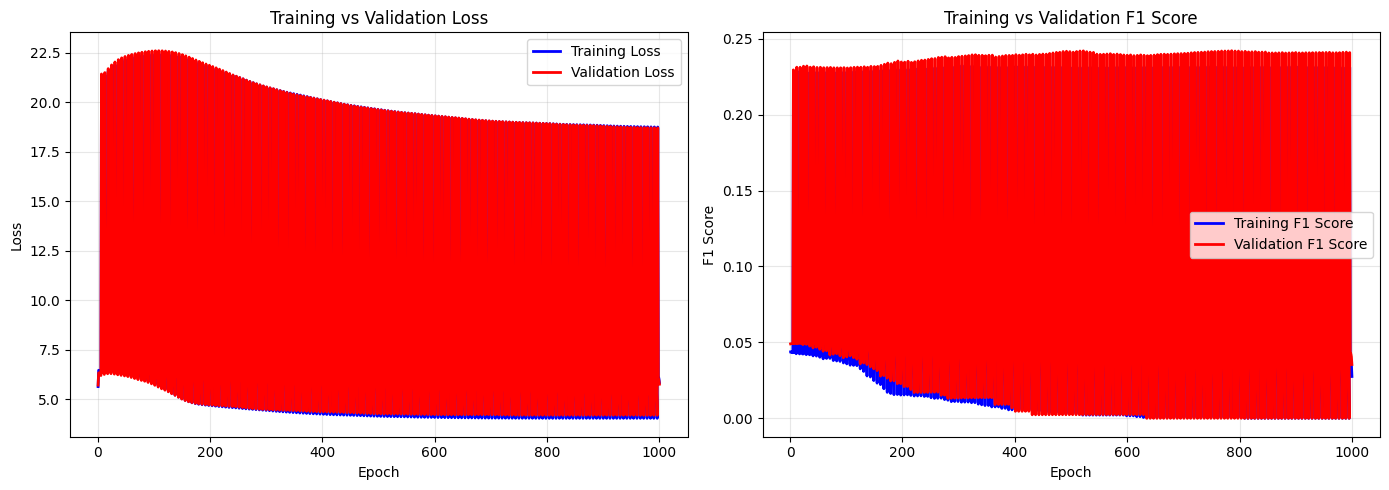

Testing trainer with params 
lr: 0.02 
epochs: 1000 
Epoch 0: Loss 5.2780, F1 Score: 0.2315
Epoch 100: Loss 6.1312, F1 Score: 0.0360
Epoch 200: Loss 6.2920, F1 Score: 0.0394
Epoch 300: Loss 4.0707, F1 Score: 0.2315
Epoch 400: Loss 5.9726, F1 Score: 0.0335
Epoch 500: Loss 6.2157, F1 Score: 0.0381
Epoch 600: Loss 4.0283, F1 Score: 0.2319
Epoch 700: Loss 5.8376, F1 Score: 0.0276
Epoch 800: Loss 6.1474, F1 Score: 0.0379
Epoch 900: Loss 4.0283, F1 Score: 0.2315

Final Test F1 Score: 3.50%
Predictions shape: (1, 6782)
Sample predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


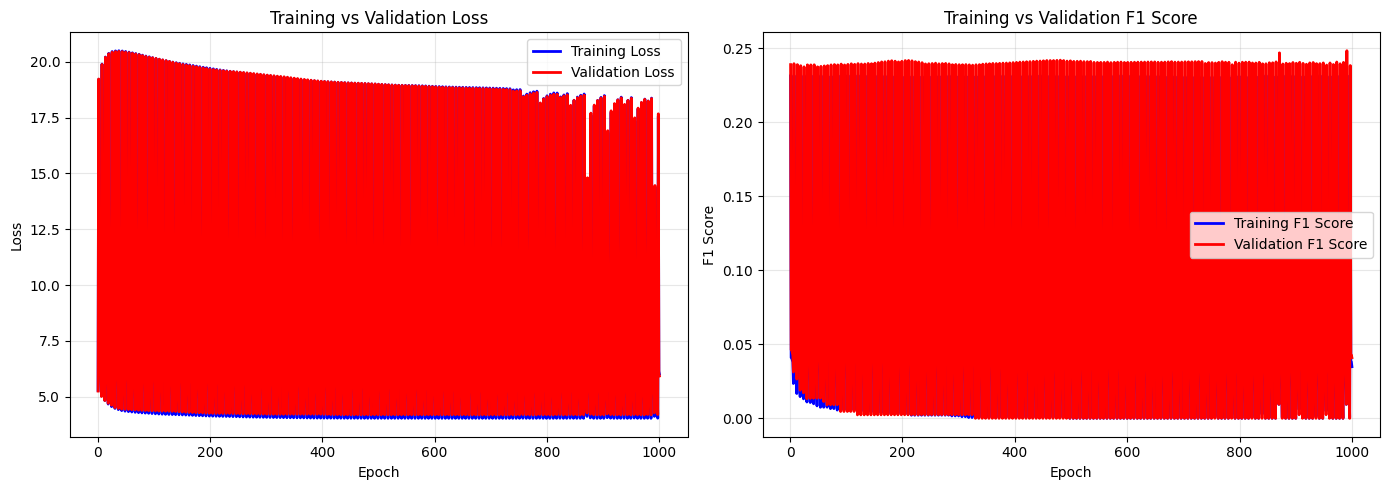

Testing trainer with params 
lr: 0.1 
epochs: 1000 
Epoch 0: Loss 5.7803, F1 Score: 0.2290
Epoch 100: Loss 6.2851, F1 Score: 0.0379
Epoch 200: Loss 6.3610, F1 Score: 0.0405
Epoch 300: Loss 4.2417, F1 Score: 0.2320
Epoch 400: Loss 6.0845, F1 Score: 0.0351
Epoch 500: Loss 6.2628, F1 Score: 0.0394
Epoch 600: Loss 4.0370, F1 Score: 0.2317
Epoch 700: Loss 5.9226, F1 Score: 0.0310
Epoch 800: Loss 6.1963, F1 Score: 0.0376
Epoch 900: Loss 4.0283, F1 Score: 0.2310

Final Test F1 Score: 3.50%
Predictions shape: (1, 6782)
Sample predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


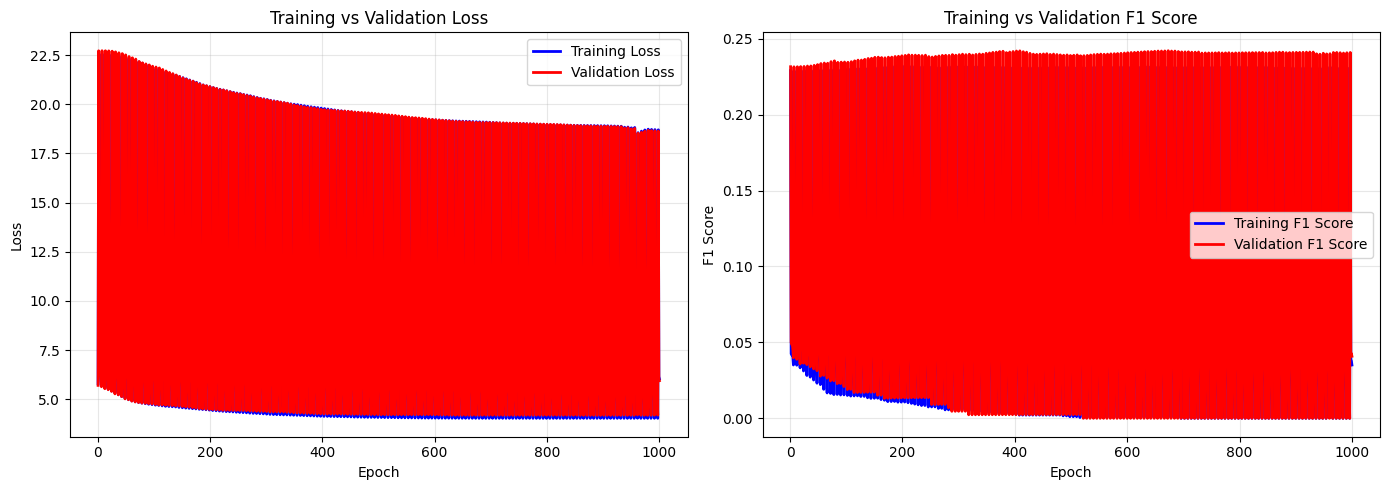

Testing trainer with params 
lr: 0.01 
epochs: 10000 
Epoch 0: Loss 5.8101, F1 Score: 0.0350
Epoch 100: Loss 4.0294, F1 Score: 0.0000
Epoch 200: Loss 4.0315, F1 Score: 0.0000
Epoch 300: Loss 4.0305, F1 Score: 0.0000
Epoch 400: Loss 4.0348, F1 Score: 0.0000
Epoch 500: Loss 4.0326, F1 Score: 0.1785
Epoch 600: Loss 4.0381, F1 Score: 0.0000
Epoch 700: Loss 4.0381, F1 Score: 0.0000
Epoch 800: Loss 4.1005, F1 Score: 0.0005
Epoch 900: Loss 4.6548, F1 Score: 0.0000
Epoch 1000: Loss 4.1134, F1 Score: 0.0005
Epoch 1100: Loss 4.0283, F1 Score: 0.1798
Epoch 1200: Loss 4.0528, F1 Score: 0.0000
Epoch 1300: Loss 4.0641, F1 Score: 0.1763
Epoch 1400: Loss 4.1965, F1 Score: 0.0883
Epoch 1500: Loss 4.0283, F1 Score: 0.1916
Epoch 1600: Loss 6.2450, F1 Score: 0.0042
Epoch 1700: Loss 6.9303, F1 Score: 0.0065
Epoch 1800: Loss 4.0283, F1 Score: 0.1982
Epoch 1900: Loss 9.3808, F1 Score: 0.0128
Epoch 2000: Loss 9.4036, F1 Score: 0.0136
Epoch 2100: Loss 9.4280, F1 Score: 0.0144
Epoch 2200: Loss 9.4474, F1 Score:

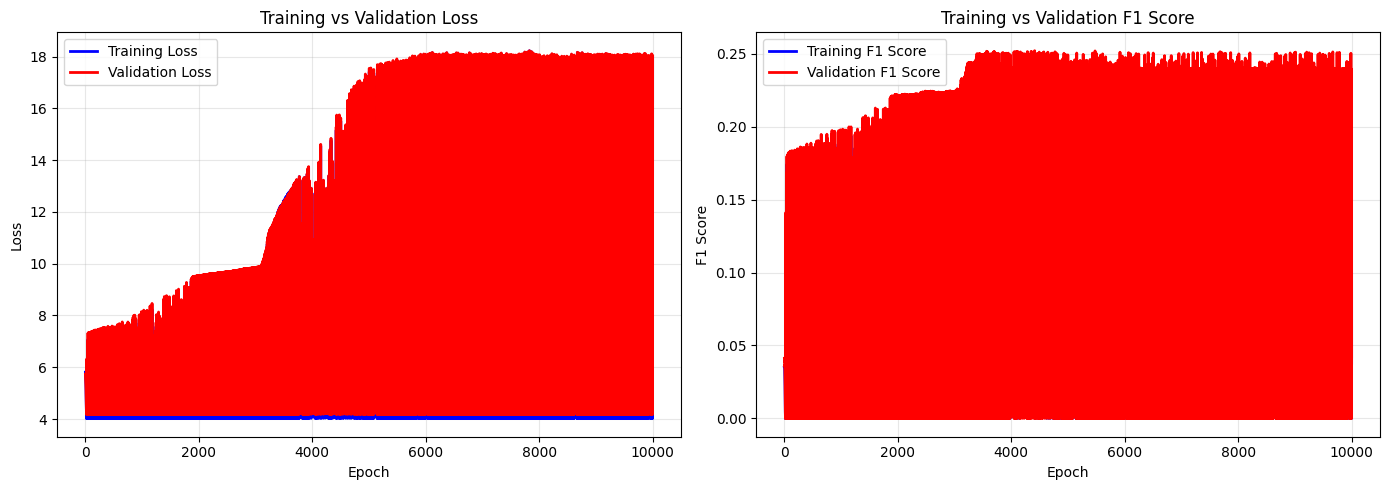

Testing trainer with params 
lr: 0.001 
epochs: 1000 
Epoch 0: Loss 6.1183, F1 Score: 0.0381
Epoch 100: Loss 4.0283, F1 Score: 0.1374
Epoch 200: Loss 4.3362, F1 Score: 0.0038
Epoch 300: Loss 4.0283, F1 Score: 0.1685
Epoch 400: Loss 4.0294, F1 Score: 0.1746
Epoch 500: Loss 4.0283, F1 Score: 0.1611
Epoch 600: Loss 4.0305, F1 Score: 0.1759
Epoch 700: Loss 4.0283, F1 Score: 0.1758
Epoch 800: Loss 4.0283, F1 Score: 0.1520
Epoch 900: Loss 6.7230, F1 Score: 0.0021

Final Test F1 Score: 0.00%
Predictions shape: (1, 6782)
Sample predictions: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


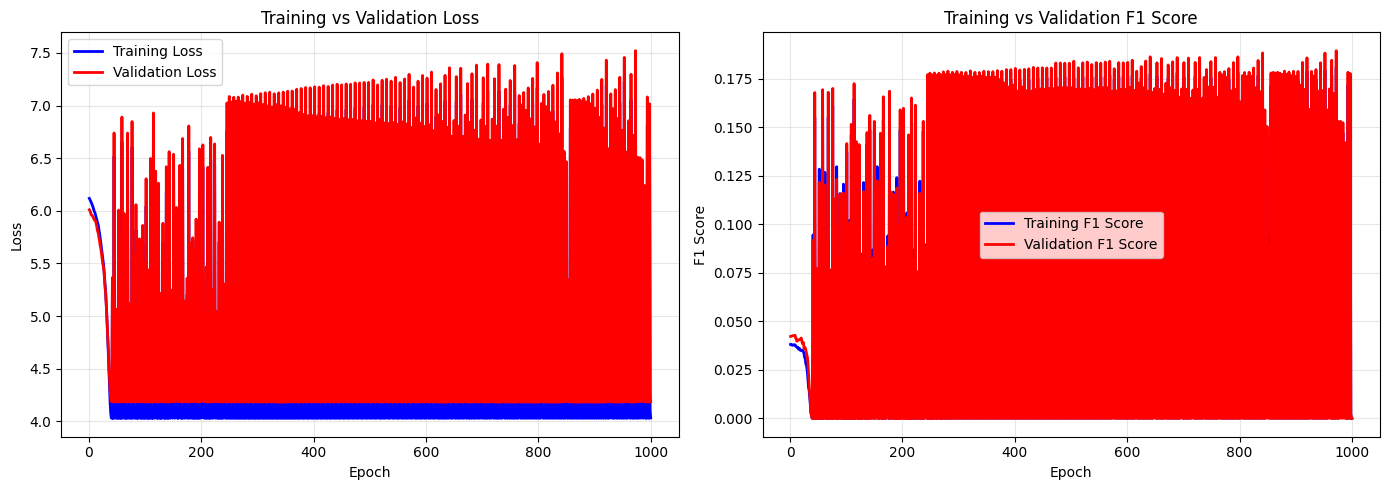

In [9]:
from util import test_trainers

# trainers to test
trainers = [trainer, trainer1, trainer2, trainer3, trainer4]

# test all the trainers
test_trainers(trainers=trainers, x_train=x_train_t, y_train=y_train, x_val=x_val_t, y_val=y_val, x_test=x_test_t, y_test=y_test)

### Perceptron in Torch

Epoch 0: Train Loss = 71.3184, Train F1 = 0.2165
Epoch 100: Train Loss = 64.9046, Train F1 = 0.2255
Epoch 200: Train Loss = 14.0766, Train F1 = 0.0398
Epoch 300: Train Loss = 14.3040, Train F1 = 0.0393
Epoch 400: Train Loss = 14.3803, Train F1 = 0.0393
Epoch 500: Train Loss = 15.0424, Train F1 = 0.0398
Epoch 600: Train Loss = 15.1257, Train F1 = 0.0400
Epoch 700: Train Loss = 12.9813, Train F1 = 0.0376
Epoch 800: Train Loss = 13.5693, Train F1 = 0.0383
Epoch 900: Train Loss = 12.1352, Train F1 = 0.0357

Final Train F1 Score: 0.0358
Final Val F1 Score: 0.0404


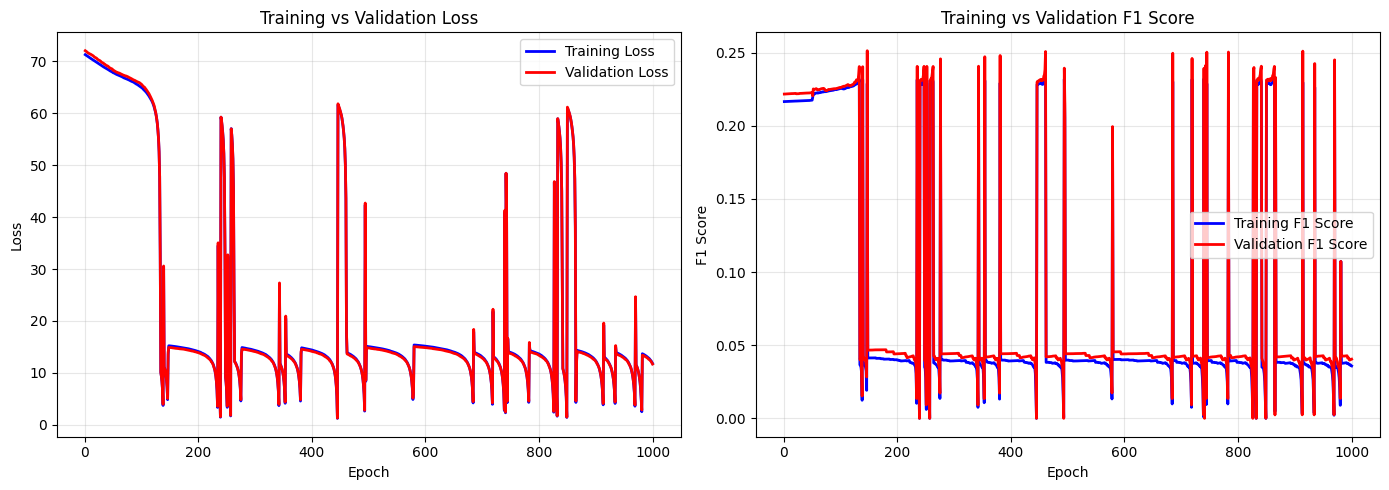

In [10]:
from perceptron_nn import Perceptron

perceptron_nn = Perceptron(x_train=x_train, y_train=y_train, x_val=x_val, y_val = y_val)

# Perform the training
perceptron_nn.train()

# Visualize the training loss and accuracy
perceptron_nn.plot_metrics()

### Analysis of the results

Above we have charts presenting loss and f1 score changing as training proceeds.
Ideally we would like to see loss decreasing and f1 increasing.
On all the graphs we can see high variations as epochs go, represented as huge blocks of red.

Model memorized training data. That can be deduced by looking at relatively small training loss, huge variations on red validation data and blue training data, hidden behind red.
Same goes for the validation f1 resembling a comb.